# **신용거래 이상탐지 데이터 다루기**
_ 20260219  

* 신용카드 이상감지 모델을 만들기 위한 데이터이며, [is_fraud]가 사기거래 여부를 나타내는 변수이다.   

**Step 1.** 필수  
- 1. 사기거래 여부를 예측하는데 불필요한 컬럼을 제거  
- 2. 최소 2개 이상의 새로운 피처(변수)를 생성해본다.  
     (hint) 구매 금액, 시간 등의 변수 이용  

**Step 2.** 추가  
- 데이터의 위도/경도 정보 활용  
- 통계적 관점으로 접근하여 유용한 변수 생성  

**[학습목표]**  
- 컬럼 이름의 변경이 명확하게 반영되어 있고, 다양한 방법으로 효과적인 결측치 처리를 진행할 수 있는가?  
- 데이터 안의 이상치를 감지하고, 이를 적절하게 수정할 수 있는가?  
- 주어진 변수에서 추가적인 변수를 생성해 낼 수 있는가?  

**[평가기준]**  
- 컬럼 이름의 변경이 명확하게 반영되어 있고, 다양한 방법으로 효과적인 결측치 처리를 진행할수 있는가?  
- 데이터의 이상치를 감지하여 수정하고 수정후 데이터의 일관성이 유지되며 품질 또한 향상 되었는가?  
- 추가적인 변수를 창의적으로 생성하고 유용하게 데이터 분석에 기여 하였는가?  





In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats 

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA 
from sklearn.metrics import (classification_report, roc_curve, auc, 
                             precision_recall_curve, confusion_matrix, f1_score, brier_score_loss)
from sklearn.calibration import calibration_curve
from sklearn.pipeline import Pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')


In [6]:
# 데이터 불러오기
cc_df = pd.read_csv('fraud.csv')

In [7]:
pd.set_option('display.max_columns',None)

In [8]:
# 데이터 형태 확인
cc_df.shape

(491134, 22)

In [9]:
# 데이터 컬럼명, 데이터 타입(수치형, 범주형) 확인, 결측치 확인
cc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491134 entries, 0 to 491133
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trans_date_trans_time  491134 non-null  object 
 1   cc_num                 491134 non-null  int64  
 2   merchant               491134 non-null  object 
 3   category               491134 non-null  object 
 4   amt                    491134 non-null  float64
 5   first                  491134 non-null  object 
 6   last                   491134 non-null  object 
 7   gender                 491134 non-null  object 
 8   street                 491134 non-null  object 
 9   city                   491134 non-null  object 
 10  state                  491134 non-null  object 
 11  zip                    491134 non-null  int64  
 12  lat                    491134 non-null  float64
 13  long                   491134 non-null  float64
 14  city_pop               491134 non-nu

In [10]:
cc_df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
1,2019-01-01 00:12:34,4956828990005111019,"fraud_Schultz, Simonis and Little",grocery_pos,44.71,Kenneth,Robinson,M,269 Sanchez Rapids,Elizabeth,NJ,7208,40.6747,-74.2239,124967,Operational researcher,1980-12-21,09eff9c806365e2a6be12c1bbab3d70e,1325376754,40.079588,-74.848087,0
2,2019-01-01 00:17:16,180048185037117,fraud_Kling-Grant,grocery_net,46.28,Mary,Wall,F,2481 Mills Lock,Plainfield,NJ,7060,40.6152,-74.4150,71485,Leisure centre manager,1974-07-19,19e23c6a300c774354417befe4f31f8c,1325377036,40.021888,-74.228188,0
3,2019-01-01 00:20:15,374930071163758,fraud_Deckow-O'Conner,grocery_pos,64.09,Daniel,Escobar,M,61390 Hayes Port,Romulus,MI,48174,42.2203,-83.3583,31515,Police officer,1971-11-05,6f363661ba6b55889e488dd178f2a0af,1325377215,42.360426,-83.552316,0
4,2019-01-01 00:23:41,2712209726293386,fraud_Balistreri-Nader,misc_pos,25.58,Jenna,Brooks,F,50872 Alex Plain Suite 088,Baton Rouge,LA,70808,30.4066,-91.1468,378909,"Designer, furniture",1977-02-22,1654da2abfb9e79a5f99167fc9779558,1325377421,29.737426,-90.853194,0


In [11]:
cc_df.describe().T

,count,mean,std,min,25%,50%,75%,max
cc_num,491134.0,3.706013e+17,1.260229e+18,5.038744e+11,2.131124e+14,3.531130e+15,4.653879e+15,4.956829e+18
amt,491134.0,6.905012e+01,1.603229e+02,1.000000e+00,8.960000e+00,4.217000e+01,8.033000e+01,2.508694e+04
zip,491134.0,5.077053e+04,2.685495e+04,1.843000e+03,2.840500e+04,4.962800e+04,7.504800e+04,9.932300e+04
lat,491134.0,3.793123e+01,5.341193e+00,2.465570e+01,3.374670e+01,3.850720e+01,4.152050e+01,4.888780e+01
long,491134.0,-9.049562e+01,1.299073e+01,-1.223456e+02,-9.723510e+01,-8.759170e+01,-8.073100e+01,-6.996560e+01
city_pop,491134.0,1.213922e+05,3.725751e+05,4.600000e+01,1.228000e+03,5.760000e+03,5.083500e+04,2.906700e+06
unix_time,491134.0,1.358730e+09,1.819402e+07,1.325376e+09,1.343087e+09,1.357257e+09,1.374626e+09,1.388534e+09
merch_lat,491134.0,3.793027e+01,5.372986e+00,2.365579e+01,3.378139e+01,3.854512e+01,4.162429e+01,4.988752e+01
merch_long,491134.0,-9.049541e+01,1.300410e+01,-1.233451e+02,-9.698481e+01,-8.757344e+01,-8.068557e+01,-6.896562e+01
is_fraud,491134.0,2.532914e-03,5.026433e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


In [12]:
# 중복데이터 확인
cc_df.duplicated().sum()

np.int64(0)

In [13]:
# 결측치 확인 : 없음
cc_df.isna().sum()

trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

=== Target Distribution ===
is_fraud
0    0.997467
1    0.002533
Name: proportion, dtype: float64


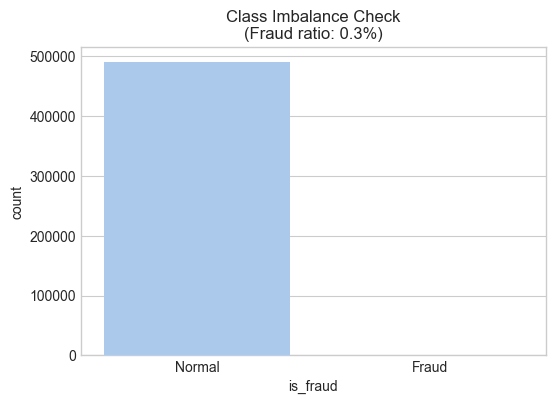

In [14]:
# 거래 중 fraud 비율 확인 : 0.3%
# 클래스 불균형 비율 계산
target_counts = cc_df['is_fraud'].value_counts(normalize=True)
print("=== Target Distribution ===")
print(target_counts)

# 시각화
plt.figure(figsize=(6, 4))
sns.countplot(x='is_fraud', data=cc_df, palette='pastel')
plt.title(f'Class Imbalance Check\n(Fraud ratio: {target_counts[1]*100:.1f}%)')
plt.xticks([0, 1], ['Normal', 'Fraud'])
plt.show()

In [15]:
# 컬럼 이름 확인 (22개 항목)
# 거래시간 (2개) : trans_date_trans_time, unix_time
# 거래정보 (6개) : merchant (사용처), category (구매품목 범주), amt(거래금액), trans_num, 거래장소 (merch_lat, merch_long)
# 고객정보 (13개): cc_num (카드번호), first(이름), last(성), gender(성별), 주소 (street, city, state, zip, lat(위도),long(경도)), job (직업), dob(생년월일), city_pop (거주도시 인구)
# 타겟 (1개): is_fraud


# lat 위도 / long 경도 -> GPS 좌표 (lat, long)
# unix_time = Epoch Time (1970년 1월 1일 00:00:00 UTS 기준 현재까지
cc_df.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud'],
      dtype='object')

날짜(trans_date_trans_time, unix_time)열 변환

In [16]:
# 날짜,시간(trans_date_trans_time, unix_time)열 datetime 변환
cc_df['trans_date_trans_time'] = pd.to_datetime(cc_df['trans_date_trans_time'])

In [17]:
# 'trans_date_trans_time' 컬럼 년도/월/일/날짜/요일/시간대 구분

# 연도
cc_df['trans_year'] = cc_df['trans_date_trans_time'].dt.year

# 월
cc_df['trans_month'] = cc_df['trans_date_trans_time'].dt.month

# 일
cc_df['trans_day'] = cc_df['trans_date_trans_time'].dt.day

# 요일 (0=Mon, 1=Tue, 2=Wed, 3=Thu, 4=Fri, 5=Sat, 6=Sun)
cc_df['trans_weekday_num'] = cc_df['trans_date_trans_time'].dt.weekday

# 요일 이름 (Mon, Tue, Wed, Thu, Fri, Sat, Sun)
cc_df['trans_weekday'] = cc_df['trans_date_trans_time'].dt.day_name().str[:3]

# 시간 (0:00 ~ 23:59)
cc_df['trans_hour'] = cc_df['trans_date_trans_time'].dt.hour

# 분
cc_df['trans_minute'] = cc_df['trans_date_trans_time'].dt.minute


In [18]:
# 'unix_time'(int)에서 datetime 변환 : 별도의 컬럼으로 생성 ('unix_time'으로 나타낸 의도 반영)
cc_df['dt_from_unix_time'] = pd.to_datetime(cc_df['unix_time'], unit='s')

In [19]:
# 변환 결과 비교
cc_df[['trans_date_trans_time','dt_from_unix_time']]

,trans_date_trans_time,dt_from_unix_time
0,2019-01-01 00:00:44,2012-01-01 00:00:44
1,2019-01-01 00:12:34,2012-01-01 00:12:34
2,2019-01-01 00:17:16,2012-01-01 00:17:16
3,2019-01-01 00:20:15,2012-01-01 00:20:15
4,2019-01-01 00:23:41,2012-01-01 00:23:41
...,...,...
491129,2020-12-31 23:56:48,2013-12-31 23:56:48
491130,2020-12-31 23:56:57,2013-12-31 23:56:57
491131,2020-12-31 23:59:09,2013-12-31 23:59:09
491132,2020-12-31 23:59:15,2013-12-31 23:59:15


In [20]:
cc_df['trans_date_trans_time'].describe()

count                           491134
mean     2020-01-21 13:08:50.095035392
min                2019-01-01 00:00:44
25%      2019-07-23 23:47:48.249999872
50%         2020-01-03 23:43:34.500000
75%         2020-07-24 00:30:18.500000
max                2020-12-31 23:59:34
Name: trans_date_trans_time, dtype: object

In [21]:
cc_df['dt_from_unix_time'].describe()

count                           491134
mean     2013-01-21 01:06:16.693315840
min                2012-01-01 00:00:44
25%      2012-07-23 23:47:48.249999872
50%         2013-01-03 23:43:34.500000
75%         2013-07-24 00:30:18.500000
max                2013-12-31 23:59:34
Name: dt_from_unix_time, dtype: object

In [22]:
cc_df['trans_date_trans_time'].dt.year.value_counts().head()

trans_date_trans_time
2020    246616
2019    244518
Name: count, dtype: int64

In [23]:
cc_df['dt_from_unix_time'].dt.year.value_counts().head()


dt_from_unix_time
2013    246616
2012    244518
Name: count, dtype: int64

In [24]:
# 2개의 컬럼이 동일한 값인지 확인 : 동일하지 않음 (7년의 gap 확인)
(cc_df['trans_date_trans_time'] == cc_df['dt_from_unix_time']).all()

np.False_

In [25]:
# 카드 개수 확인 : 124개
cc_df['cc_num'].nunique()

124

In [26]:
# 카드소유주 정보 컬럼 생성 : 카드소유주명 = first + last
cc_df['cc_owner'] = cc_df['first']+' '+cc_df['last']

In [27]:
cc_df['cc_owner'].nunique()

124

In [28]:
cc_df[['cc_num','cc_owner']]

,cc_num,cc_owner
0,630423337322,Stephanie Gill
1,4956828990005111019,Kenneth Robinson
2,180048185037117,Mary Wall
3,374930071163758,Daniel Escobar
4,2712209726293386,Jenna Brooks
...,...,...
491129,6011109736646996,Rebecca Erickson
491130,213112402583773,Ana Howell
491131,3556613125071656,Jose Vasquez
491132,6011724471098086,Ann Lawson


In [29]:
# 개인식별 ID : 이름 + 카드번호 (124개)
cc_df['cc_owner_id'] = (cc_df['cc_owner']+'_'+cc_df['cc_num'].astype(str))

In [30]:
cc_df['cc_owner_id'].nunique()

124

In [31]:
# 카드 소유주 주소 GPS 지표 생성
cc_df['home_loc'] = list(zip(cc_df['lat'], cc_df['long']))

In [32]:
# 사용처 위치 GPS 지표 생성
cc_df['merch_loc'] = list(zip(cc_df['merch_lat'], cc_df['merch_long']))

In [33]:
# 집과 가맹점 위치 거리 계산
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # km 지구 반지름
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2*np.arcsin(np.sqrt(a))
    return R * c

cc_df['distance_km'] = haversine(
    cc_df['lat'],
    cc_df['long'],
    cc_df['merch_lat'],
    cc_df['merch_long'])

In [34]:
cc_df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,trans_year,trans_month,trans_day,trans_weekday_num,trans_weekday,trans_hour,trans_minute,dt_from_unix_time,cc_owner,cc_owner_id,home_loc,merch_loc,distance_km
0,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,2019,1,1,1,Tue,0,0,2012-01-01 00:00:44,Stephanie Gill,Stephanie Gill_630423337322,"(48.8878, -118.2105)","(49.159047, -118.186462)",30.212176
1,2019-01-01 00:12:34,4956828990005111019,"fraud_Schultz, Simonis and Little",grocery_pos,44.71,Kenneth,Robinson,M,269 Sanchez Rapids,Elizabeth,NJ,7208,40.6747,-74.2239,124967,Operational researcher,1980-12-21,09eff9c806365e2a6be12c1bbab3d70e,1325376754,40.079588,-74.848087,0,2019,1,1,1,Tue,0,12,2012-01-01 00:12:34,Kenneth Robinson,Kenneth Robinson_4956828990005111019,"(40.6747, -74.2239)","(40.079588, -74.84808699999999)",84.702120
2,2019-01-01 00:17:16,180048185037117,fraud_Kling-Grant,grocery_net,46.28,Mary,Wall,F,2481 Mills Lock,Plainfield,NJ,7060,40.6152,-74.4150,71485,Leisure centre manager,1974-07-19,19e23c6a300c774354417befe4f31f8c,1325377036,40.021888,-74.228188,0,2019,1,1,1,Tue,0,17,2012-01-01 00:17:16,Mary Wall,Mary Wall_180048185037117,"(40.6152, -74.415)","(40.021888, -74.228188)",67.847742
3,2019-01-01 00:20:15,374930071163758,fraud_Deckow-O'Conner,grocery_pos,64.09,Daniel,Escobar,M,61390 Hayes Port,Romulus,MI,48174,42.2203,-83.3583,31515,Police officer,1971-11-05,6f363661ba6b55889e488dd178f2a0af,1325377215,42.360426,-83.552316,0,2019,1,1,1,Tue,0,20,2012-01-01 00:20:15,Daniel Escobar,Daniel Escobar_374930071163758,"(42.2203, -83.3583)","(42.360426, -83.552316)",22.303906
4,2019-01-01 00:23:41,2712209726293386,fraud_Balistreri-Nader,misc_pos,25.58,Jenna,Brooks,F,50872 Alex Plain Suite 088,Baton Rouge,LA,70808,30.4066,-91.1468,378909,"Designer, furniture",1977-02-22,1654da2abfb9e79a5f99167fc9779558,1325377421,29.737426,-90.853194,0,2019,1,1,1,Tue,0,23,2012-01-01 00:23:41,Jenna Brooks,Jenna Brooks_2712209726293386,"(30.4066, -91.1468)","(29.737426, -90.853194)",79.591943


z-score 계산 : 평균으로부터 몇 표준편차만큼 떨어져있는지

In [35]:
# 카드별 거래금액(amt) z-score 설정

def amt_z_func(cc_df):
    amt_info = cc_df.groupby('cc_num')['amt'].agg(['mean','std']).reset_index() # 카드별 거래금액
    cc_df = cc_df.merge(amt_info, on='cc_num',how = 'left')
    cc_df['amt_z'] = (cc_df['amt'] - cc_df['mean']) / cc_df['std']
    cc_df.drop(['mean','std'],axis=1, inplace = True)

    cat_amt_info = cc_df.groupby(['cc_num','category'])['amt'].agg(['mean','std']).reset_index() # 카드별 카데고리별 거래금액
    cc_df = cc_df.merge(cat_amt_info, on=['cc_num','category'],how = 'left')
    cc_df['cat_amt_z'] = (cc_df['amt'] - cc_df['mean']) / cc_df['std']
    cc_df.drop(['mean','std'],axis=1, inplace = True)

    return cc_df


In [36]:
cc_df = amt_z_func(cc_df)

In [37]:
# 카드별 거래거리 z-score계산
def dist_func(cc_df):
    distance_info = cc_df.groupby('cc_num')['distance_km'].agg(['mean','std']).reset_index() # 카드소유주 주소와 거래처 간 거리
    cc_df = cc_df.merge(distance_info, on='cc_num',how = 'left')
    cc_df['dist_z'] = (cc_df['distance_km'] - cc_df['mean']) / cc_df['std']
    cc_df.drop(['mean','std'],axis=1, inplace = True)

    return cc_df

In [38]:
cc_df = dist_func(cc_df)

In [39]:
# 거래 건별 거래시간대 구분

def hour_cat_func(x):
    if 0 <= x < 6:
        return 'night'
    elif 6 <= x < 12:
        return 'morning'
    elif 12 <= x < 18:
        return 'afternoon'
    else:
        return 'evening'
    
cc_df['hour_cat'] = cc_df['trans_hour'].apply(hour_cat_func)


In [40]:
# 고객별 시간대 결재 패턴 확인
def hour_func(cc_df):   
    hour_cnt = cc_df.groupby(['cc_num','hour_cat']).size().reset_index(name='hour_cnt')
    cc_df = cc_df.merge(hour_cnt, on=['cc_num','hour_cat'],how = 'left')
    hour_total = cc_df.groupby('cc_num').size().reset_index(name='hour_total')
    cc_df = cc_df.merge(hour_total, on='cc_num',how = 'left')

    cc_df['hour_ratio'] = cc_df['hour_cnt']/cc_df['hour_total']
  
    return cc_df

In [41]:
cc_df = hour_func(cc_df)

In [42]:
# 약 10% 거래
print('시간대별 거래빈도 최소비율 : ',cc_df['hour_ratio'].min())
print('시간대별 거래빈도 최대비율 : ',cc_df['hour_ratio'].max())
print('시간대별 거래빈도 평균비율 : ',cc_df['hour_ratio'].mean())

시간대별 거래빈도 최소비율 :  0.0906113537117904
시간대별 거래빈도 최대비율 :  0.4183951965065502
시간대별 거래빈도 평균비율 :  0.2995600458712188


In [43]:
cc_df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,trans_year,trans_month,trans_day,trans_weekday_num,trans_weekday,trans_hour,trans_minute,dt_from_unix_time,cc_owner,cc_owner_id,home_loc,merch_loc,distance_km,amt_z,cat_amt_z,dist_z,hour_cat,hour_cnt,hour_total,hour_ratio
0,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,2019,1,1,1,Tue,0,0,2012-01-01 00:00:44,Stephanie Gill,Stephanie Gill_630423337322,"(48.8878, -118.2105)","(49.159047, -118.186462)",30.212176,0.321302,0.317631,-1.473120,night,619,4362,0.141907
1,2019-01-01 00:12:34,4956828990005111019,"fraud_Schultz, Simonis and Little",grocery_pos,44.71,Kenneth,Robinson,M,269 Sanchez Rapids,Elizabeth,NJ,7208,40.6747,-74.2239,124967,Operational researcher,1980-12-21,09eff9c806365e2a6be12c1bbab3d70e,1325376754,40.079588,-74.848087,0,2019,1,1,1,Tue,0,12,2012-01-01 00:12:34,Kenneth Robinson,Kenneth Robinson_4956828990005111019,"(40.6747, -74.2239)","(40.079588, -74.84808699999999)",84.702120,-0.114637,-0.652060,0.345336,night,551,3657,0.150670
2,2019-01-01 00:17:16,180048185037117,fraud_Kling-Grant,grocery_net,46.28,Mary,Wall,F,2481 Mills Lock,Plainfield,NJ,7060,40.6152,-74.4150,71485,Leisure centre manager,1974-07-19,19e23c6a300c774354417befe4f31f8c,1325377036,40.021888,-74.228188,0,2019,1,1,1,Tue,0,17,2012-01-01 00:17:16,Mary Wall,Mary Wall_180048185037117,"(40.6152, -74.415)","(40.021888, -74.228188)",67.847742,-0.361802,-0.723328,-0.269201,night,655,4382,0.149475
3,2019-01-01 00:20:15,374930071163758,fraud_Deckow-O'Conner,grocery_pos,64.09,Daniel,Escobar,M,61390 Hayes Port,Romulus,MI,48174,42.2203,-83.3583,31515,Police officer,1971-11-05,6f363661ba6b55889e488dd178f2a0af,1325377215,42.360426,-83.552316,0,2019,1,1,1,Tue,0,20,2012-01-01 00:20:15,Daniel Escobar,Daniel Escobar_374930071163758,"(42.2203, -83.3583)","(42.360426, -83.552316)",22.303906,-0.001304,0.211780,-1.823391,night,557,3647,0.152728
4,2019-01-01 00:23:41,2712209726293386,fraud_Balistreri-Nader,misc_pos,25.58,Jenna,Brooks,F,50872 Alex Plain Suite 088,Baton Rouge,LA,70808,30.4066,-91.1468,378909,"Designer, furniture",1977-02-22,1654da2abfb9e79a5f99167fc9779558,1325377421,29.737426,-90.853194,0,2019,1,1,1,Tue,0,23,2012-01-01 00:23:41,Jenna Brooks,Jenna Brooks_2712209726293386,"(30.4066, -91.1468)","(29.737426, -90.853194)",79.591943,-0.393828,-0.575698,0.006507,night,624,4372,0.142726


In [44]:
# 카드 소유주 나이계산
def age_func(cc_df):
    cc_df['age'] = cc_df['trans_year']-pd.to_datetime(cc_df['dob']).dt.year
    return cc_df

In [45]:
cc_df = age_func(cc_df)

불필요한 컬럼 정리

In [46]:
cc_df.columns.unique()

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud', 'trans_year', 'trans_month', 'trans_day',
       'trans_weekday_num', 'trans_weekday', 'trans_hour', 'trans_minute',
       'dt_from_unix_time', 'cc_owner', 'cc_owner_id', 'home_loc', 'merch_loc',
       'distance_km', 'amt_z', 'cat_amt_z', 'dist_z', 'hour_cat', 'hour_cnt',
       'hour_total', 'hour_ratio', 'age'],
      dtype='object')

In [47]:
cc_clean_df = cc_df.drop(['merchant','first', 'last','street', 'city', 'state', 'zip', 'lat','long','job', 'dob', 'trans_num','merch_lat','merch_long','cc_owner'], axis=1)

In [48]:
cc_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491134 entries, 0 to 491133
Data columns (total 28 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   trans_date_trans_time  491134 non-null  datetime64[ns]
 1   cc_num                 491134 non-null  int64         
 2   category               491134 non-null  object        
 3   amt                    491134 non-null  float64       
 4   gender                 491134 non-null  object        
 5   city_pop               491134 non-null  int64         
 6   unix_time              491134 non-null  int64         
 7   is_fraud               491134 non-null  int64         
 8   trans_year             491134 non-null  int32         
 9   trans_month            491134 non-null  int32         
 10  trans_day              491134 non-null  int32         
 11  trans_weekday_num      491134 non-null  int32         
 12  trans_weekday          491134 non-null  obje

이상값 확인

In [49]:
cc_clean_df.columns.unique()

Index(['trans_date_trans_time', 'cc_num', 'category', 'amt', 'gender',
       'city_pop', 'unix_time', 'is_fraud', 'trans_year', 'trans_month',
       'trans_day', 'trans_weekday_num', 'trans_weekday', 'trans_hour',
       'trans_minute', 'dt_from_unix_time', 'cc_owner_id', 'home_loc',
       'merch_loc', 'distance_km', 'amt_z', 'cat_amt_z', 'dist_z', 'hour_cat',
       'hour_cnt', 'hour_total', 'hour_ratio', 'age'],
      dtype='object')

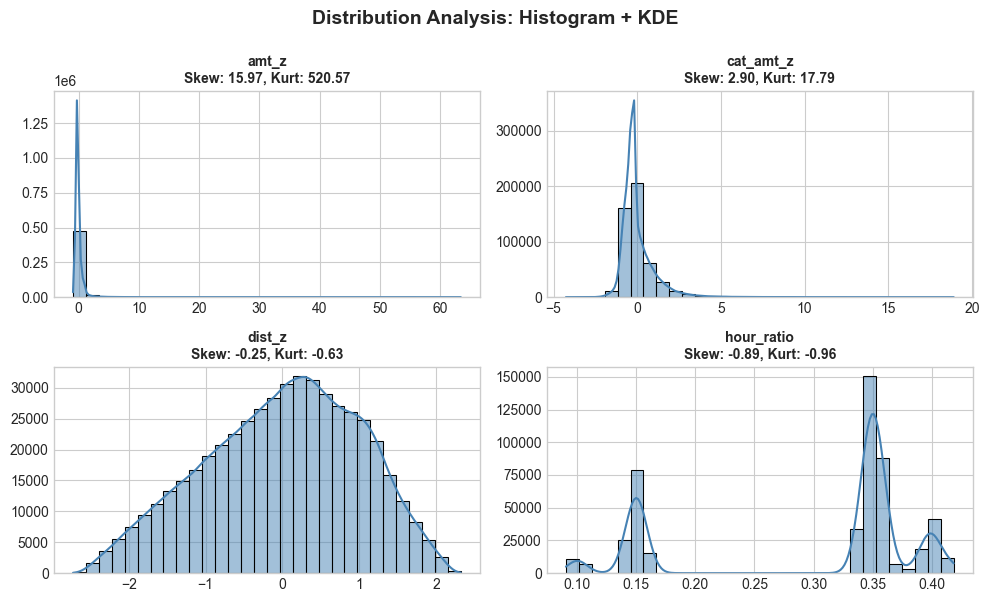


📊 Skewness & Kurtosis Summary (절댓값 큰 순서):


,Feature,Skewness,Kurtosis
0,amt_z,15.966320,520.567276
1,cat_amt_z,2.897571,17.790165
3,hour_ratio,-0.887327,-0.960705
2,dist_z,-0.246137,-0.627363


In [50]:
# z-score 변환데이터 등 그래프 확인

z_cols = ['amt_z', 'cat_amt_z', 'dist_z','hour_ratio']

# 분포 시각화
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes = axes.ravel()

for i, col in enumerate(z_cols):
    ax = axes[i]
    sns.histplot(cc_clean_df[col], kde=True, ax=ax, color='steelblue', bins=30)

    # Skewness 계산
    skew = cc_clean_df[col].skew()
    kurt = cc_clean_df[col].kurtosis()

    ax.set_title(f'{col}\nSkew: {skew:.2f}, Kurt: {kurt:.2f}', fontsize=10, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('')

# 빈 subplot 제거
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Distribution Analysis: Histogram + KDE', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Skewness 요약 테이블
skew_summary = pd.DataFrame({
    'Feature': z_cols,
    'Skewness': [cc_clean_df[col].skew() for col in z_cols],
    'Kurtosis': [cc_clean_df[col].kurtosis() for col in z_cols]
}).sort_values('Skewness', key=abs, ascending=False)

print("\n📊 Skewness & Kurtosis Summary (절댓값 큰 순서):")
display(skew_summary)

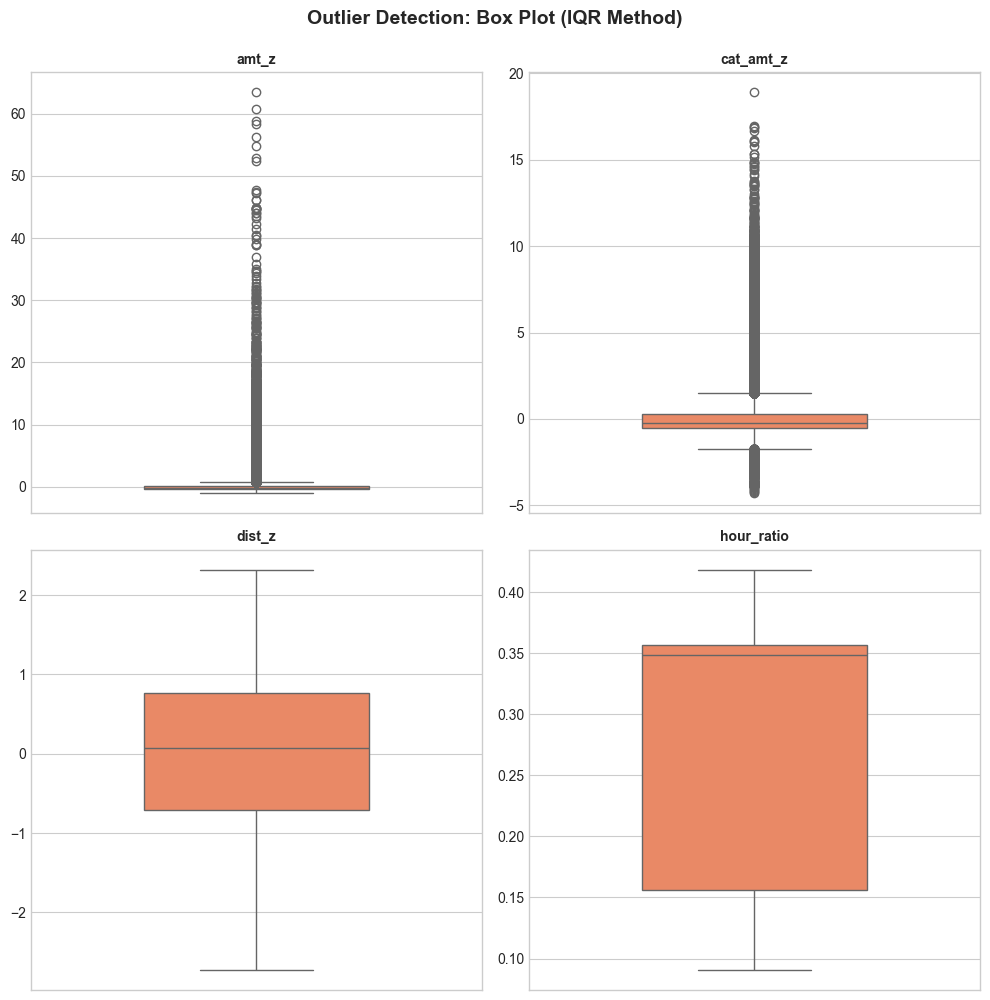


📊 Outlier Summary (IQR Method):


,Feature,Outlier_Count,Outlier_Ratio(%)
1,cat_amt_z,36014,7.33
0,amt_z,35437,7.22
2,dist_z,0,0.00
3,hour_ratio,0,0.00


In [51]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.ravel()

outlier_summary = []

for i, col in enumerate(z_cols):
    ax = axes[i]
    sns.boxplot(y=cc_clean_df[col], ax=ax, color='coral', width=0.5)
    ax.set_title(f'{col}', fontsize=10, fontweight='bold')
    ax.set_ylabel('')

    # IQR 기반 이상치 계산
    Q1 = cc_clean_df[col].quantile(0.25)
    Q3 = cc_clean_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = cc_clean_df[(cc_clean_df[col] < lower) | (cc_clean_df[col] > upper)]
    outlier_count = len(outliers)
    outlier_ratio = outlier_count / len(cc_clean_df) * 100

    outlier_summary.append({
        'Feature': col,
        'Outlier_Count': outlier_count,
        'Outlier_Ratio(%)': round(outlier_ratio, 2)
    })

# 빈 subplot 제거
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Outlier Detection: Box Plot (IQR Method)', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# 이상치 요약
outlier_df = pd.DataFrame(outlier_summary).sort_values('Outlier_Count', ascending=False)
print("\n📊 Outlier Summary (IQR Method):")
display(outlier_df)


In [52]:
cc_clean_df.groupby('is_fraud')[['amt_z', 'cat_amt_z', 'dist_z','hour_ratio','distance_km']].mean()

,amt_z,cat_amt_z,dist_z,hour_ratio,distance_km
is_fraud,,,,,
0,-0.007444,-0.007959,-0.000037,0.299697,76.377667
1,2.931319,3.134379,0.014690,0.245584,76.763829


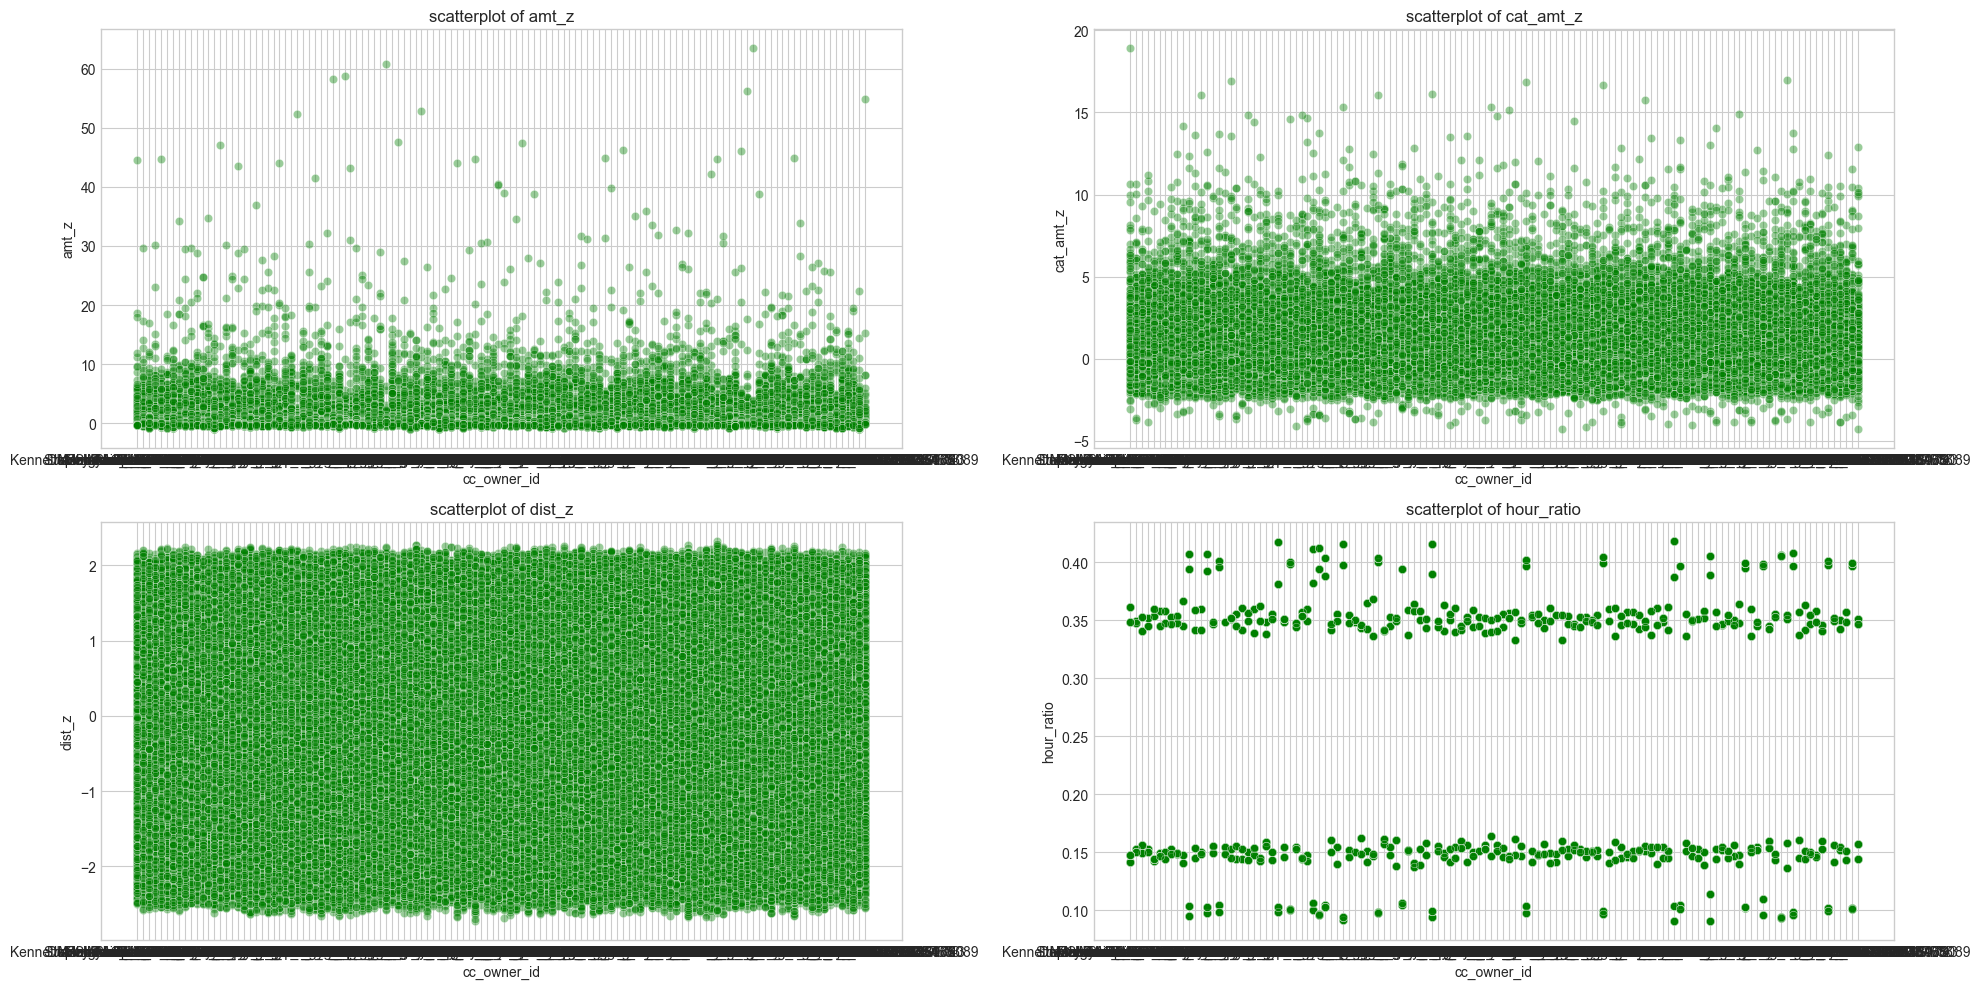

In [53]:
# 'cc_num'와 나머지 숫자형 변수와 비교
plt.figure(figsize=(20,10))
for i, col in enumerate(z_cols):
    plt.subplot(2,2,i+1)
    sns.scatterplot(x='cc_owner_id',y=cc_clean_df[col], data=cc_clean_df, color='green', alpha=0.4)
    plt.title(f'scatterplot of {col}')
plt.tight_layout()
plt.show()

Boruta 변수 선택(Shadow Feature Method)

In [54]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(max_iter=1000, class_weight='balanced')

In [55]:
feature_cols = ['amt', 'distance_km',
    'amt_z', 'cat_amt_z', 'dist_z',
    'trans_hour','hour_ratio',
]

# 확인되지 않은 결측에 대한 제거
model_df = cc_clean_df.dropna(subset=feature_cols + ['is_fraud']).copy()

X = model_df[feature_cols]
y = model_df['is_fraud'].astype(int)

In [56]:
# 시간기준 train/test 분리
model_df = model_df.sort_values('trans_date_trans_time')

split_idx = int(len(model_df)*0.8)
train_df = model_df.iloc[:split_idx]
test_df  = model_df.iloc[split_idx:]

X_train, y_train = train_df[feature_cols], train_df['is_fraud'].astype(int)
X_test,  y_test  = test_df[feature_cols],  test_df['is_fraud'].astype(int)


🎭 Boruta Matrix Shape (Real + Shadow): (491134, 14)


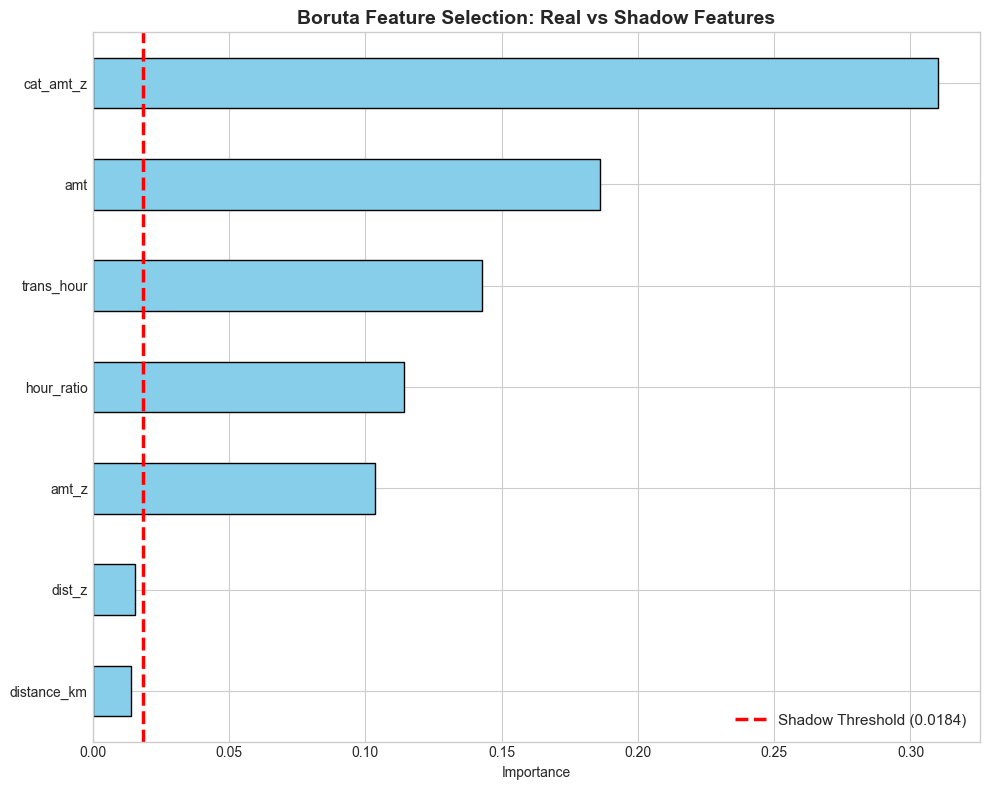


✅ Selected Features (5개):
['amt', 'amt_z', 'cat_amt_z', 'trans_hour', 'hour_ratio']

❌ Rejected Features (2개):
['distance_km', 'dist_z']

📊 Final Feature Matrix Shape: (491134, 5)


In [57]:
# Shadow Feature 생성
np.random.seed(42)
X_shadow = X.apply(np.random.permutation)
X_shadow.columns = ['Shadow_' + c for c in X.columns]
X_boruta = pd.concat([X, X_shadow], axis=1)

print(f"\n🎭 Boruta Matrix Shape (Real + Shadow): {X_boruta.shape}")

# Random Forest 검증 (빠른 검증용)
rf_boruta = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10, 
    random_state=42, 
    n_jobs=-1
)
rf_boruta.fit(X_boruta, y)

# Importance 비교
importances = pd.Series(rf_boruta.feature_importances_, index=X_boruta.columns)
real_imp = importances[:len(X.columns)]
shadow_imp = importances[len(X.columns):]
max_shadow = shadow_imp.max()

# 시각화
plt.figure(figsize=(10, 8))
real_imp.sort_values().plot(kind='barh', color='skyblue', edgecolor='black')
plt.axvline(max_shadow, color='red', linestyle='--', linewidth=2.5, label=f'Shadow Threshold ({max_shadow:.4f})')
plt.title('Boruta Feature Selection: Real vs Shadow Features', fontsize=14, fontweight='bold')
plt.xlabel('Importance')
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

# 최종 변수 선택
selected_features = real_imp[real_imp > max_shadow].index.tolist()
rejected_features = real_imp[real_imp <= max_shadow].index.tolist()

print(f"\n✅ Selected Features ({len(selected_features)}개):")
print(selected_features)

print(f"\n❌ Rejected Features ({len(rejected_features)}개):")
print(rejected_features)

X_final = X[selected_features]
print(f"\n📊 Final Feature Matrix Shape: {X_final.shape}")

모델링

In [58]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)

X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced_subsample'
)

In [ ]:
param_dist = {
    'max_depth': [None, 8, 12, 16],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 0.5, None]
}

search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=15,
    scoring='average_precision',   # PR-AUC 기준 (불균형에 강함)
    cv=3,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train, y_train)   # SMOTE 썼으면 X_train_res, y_train_res
best_rf = search.best_estimator_